In [1]:
from igraph import *
import pickle
import folium
import shapely.geometry as sg
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import ast

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')


In [4]:
data=pd.read_csv('SF_human_paths_5emej.csv').dropna()
with (open("Human_path_30m_Nofilt_sf.pk", "rb")) as file:
    path_g=pickle.load(file, encoding='latin1')
    
with (open("SF_network_matched.pickle", "rb")) as file:
    net=pickle.load(file, encoding='latin1')    
    
data['path']=data['pathID'].map(path_g)

In [14]:
##Street network
l=[]
for i in range(len(net.es())):
    l.append([i,net.es[i].source,net.es[i].target,net.vs[net.es[i].source]['pos'],net.vs[net.es[i].target]['pos']])

In [18]:
pd.DataFrame(l,columns=['segID','sourceID','targetID','source_pos','target_pos']).to_csv('SF_network.csv',index=False)

In [7]:
data

,pathID,path,startT,length
0,f4590af28598a295d5eabdf40e5b395e,"[7334, 27058]",2015-02-03 09:07:04,67.619333
1,128f1a77ef28ccfdd8081daa2203dac4,"[7335, 7337, 7336, 7332, 7340, 7333]",2014-10-14 07:54:43,157.534214
2,73c52f730234b9bd4f435ed573a77875,"[8300, 8303, 8694, 44802, 8695]",2014-12-04 10:05:38,353.499750
3,53afbb782a7dde7b2617e53f535e7bc8,"[30169, 30161, 19908]",2014-08-30 12:29:42,81.738000
4,76d12e654ddaacfe70d599ba03e40199,"[10787, 10786, 10784, 33715, 14101, 14100, 255...",2014-10-17 18:53:56,947.515790
...,...,...,...,...
246432,88807a0551d8e9836e544361a0824de2,"[7844, 7843, 7842, 7841, 7840, 7838, 7839, 783...",2015-03-02 17:47:30,590.793119
246433,fb15cf27cbec2511d8f7a3365647d377,"[27000, 23482, 23440, 23441, 23442, 23523, 235...",2014-11-07 14:31:02,3663.913000
246434,159c0ba0cdda68640d432f07d5d740c4,"[12552, 29710, 28683, 21693, 37919, 22473, 199...",2015-03-15 00:24:03,570.387667
246435,103c3a69502e60dde39ad366cf9c38c8,"[13755, 13756, 47057, 12231, 7451]",2014-07-22 13:15:27,302.346000


### Add OD coordinates

In [16]:
data['origin']=data['path'].apply(lambda x:x[0])
data['destination']=data['path'].apply(lambda x:x[-1])

In [20]:
data['O_network']=data['origin'].apply(lambda x:net.vs[x]['pos'])
data['D_network']=data['destination'].apply(lambda x:net.vs[x]['pos'])

### Simulate shortest paths

In [27]:
data[['origin','destination']].values
#net.get_shortest_paths(7335 , 7333, weights=net.es['weight'])

array([[ 7334, 27058],
       [ 7335,  7333],
       [ 8300,  8695],
       ...,
       [12552, 18234],
       [13755,  7451],
       [10492, 39381]])

In [43]:
def get_short(origin,destination):
    return net.get_shortest_paths(origin , destination, weights=net.es['weight'])[0]
# [net.get_shortest_paths(o , d, weights=net.es['weight']) for o,d in data[['origin','destination']].values]

In [46]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=2)
import time
t=time.time()
shortest_paths=data.parallel_apply(lambda x: get_short(x['origin'],x['destination']),axis=1)

print(time.time()-t)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
534.5503070354462


In [49]:
data['shortest_path']=shortest_paths

In [53]:
# data[['pathID','path','O_network','D_network','startT','length','shortest_path']].to_csv('SF_trip_data.csv',index=False)

In [59]:
linked_segs=data['path'].apply(lambda x:[str(x[i])+'_'+str(x[i+1]) for i in range(len(x)-1)])
linked_segs_shortest=data['shortest_path'].apply(lambda x:[str(x[i])+'_'+str(x[i+1]) for i in range(len(x)-1)])

In [65]:
pathid=data['pathID'].tolist()

In [67]:
path_rec=[(pathid[j],linked_segs[j][i]) for j in range(len(linked_segs.tolist())) for i in range(len(linked_segs[j]))]
path_rec_shortest=[(pathid[j],linked_segs_shortest[j][i]) for j in range(len(linked_segs_shortest.tolist())) for i in range(len(linked_segs_shortest[j]))]

In [70]:
pd.DataFrame(path_rec,columns=['pathID','seg']).to_csv('trip_segments.csv',index=False)
pd.DataFrame(path_rec_shortest,columns=['pathID','seg']).to_csv('trip_segments_shortest.csv',index=False)

In [76]:
data[['pathID','startT','length','O_network','D_network']].to_csv('SF_trip_data.csv',index=False)

### Create geoJSON

In [3]:
from geojson import Point, Feature, FeatureCollection, dump, LineString
import geopandas as gpd

In [41]:
seg_id=[i for i in range(len(net.es()))]
coords=[(net.vs[net.es[i].source]['pos'],net.vs[net.es[i].target]['pos']) for i in seg_id]
origin=[net.es[i].source for i in seg_id]
dest=[net.es[i].target for i in seg_id]


In [43]:
features = []
for i in seg_id:
    features.append(Feature(geometry=LineString((coords[i][0][::-1],coords[i][1][::-1])), properties={"segment_id": i,"source_node":origin[i],"target_node":dest[i]}))

In [ ]:
Feature(geometry=LineString, properties={"country": "Spain"})

In [25]:
LineString((coords[0][0],coords[0][1]))

{"coordinates": [[37.91549, -122.51313], [37.915682, -122.514049]], "type": "LineString"}

In [45]:
# len(features)

In [48]:
feature_collection = FeatureCollection(features)

with open('SF_street_segment_graph.geojson', 'w') as f:
    dump(feature_collection, f)

In [35]:
# features

In [80]:
mapping=gpd.read_file('SF_street_segment_graph.geojson')

In [81]:
mapping.head()

,segment_id,source_node,target_node,geometry
0,0,23856,50257,"LINESTRING (-122.51313 37.91549, -122.51405 37..."
1,1,14032,14160,"LINESTRING (-122.47773 37.74110, -122.47665 37..."
2,2,28444,28445,"LINESTRING (-122.45877 37.67706, -122.45868 37..."
3,3,8844,45216,"LINESTRING (-122.48535 37.74263, -122.48599 37..."
4,4,19581,19582,"LINESTRING (-122.42448 37.70681, -122.42468 37..."


In [15]:
mapping[(mapping['source_node']==7845) & (mapping['target_node']==26952)]

,segment_id,source_node,target_node,geometry
37046,37046,7845,26952,"LINESTRING (-122.38753 37.74406, -122.38744 37..."


In [ ]:
26952_7845

<AxesSubplot:>

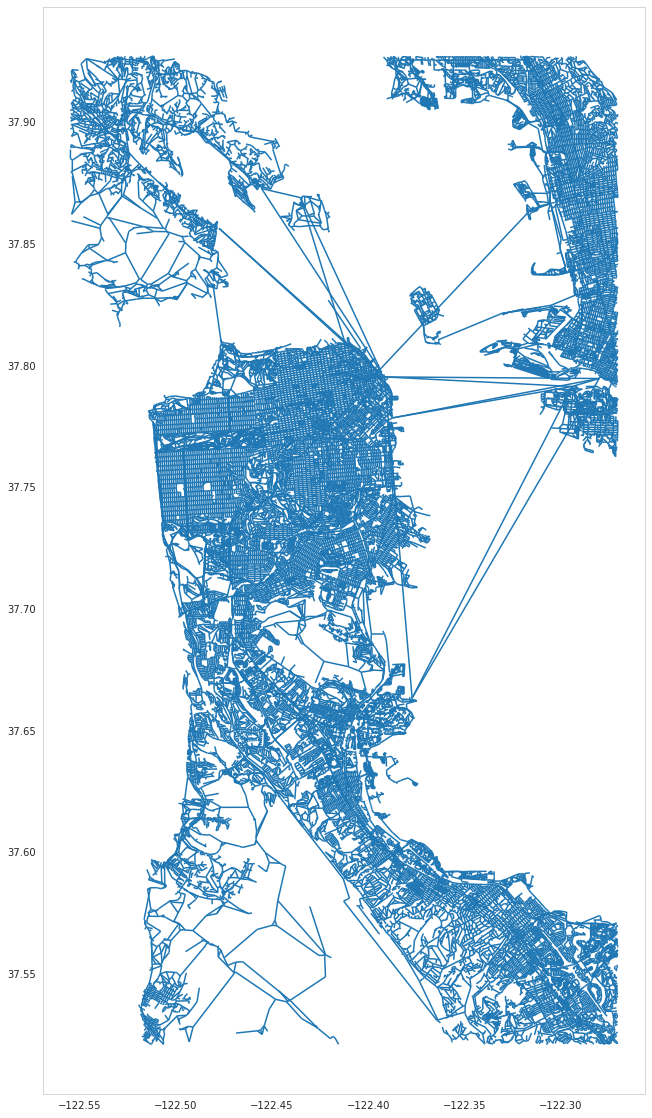

In [9]:
fig,ax=plt.subplots(figsize=(40,20))
ax.grid(False)
mapping.plot(ax=ax)

In [4]:
d={'a':1,'b':3,'c':2}
sorted(d.items(), key=lambda item: item[1],reverse=True)

[('b', 3), ('c', 2), ('a', 1)]

In [53]:
# graph_segs=(mapping['source_node'].astype(str)+'_'+mapping['target_node'].astype(str)).tolist()
# graph_segs_flipped=(mapping['target_node'].astype(str)+'_'+mapping['source_node'].astype(str)).tolist()
# s=set(graph_segs+graph_segs_flipped)
# trip_segs=pd.read_csv('trip_segments.csv')['seg'].values
# all([t in s for t in trip_segs])

# Added this to draw Boston map to add to my report

In [19]:
with (open("boston_network_normal_park.pk", "rb")) as file:
    net=pickle.load(file, encoding='latin1')    

seg_id=[i for i in range(len(net.es()))]
coords=[(net.vs[net.es[i].source]['pos'],net.vs[net.es[i].target]['pos']) for i in seg_id]
origin=[net.es[i].source for i in seg_id]

dest=[net.es[i].target for i in seg_id]
features = []
for i in seg_id:
    features.append(Feature(geometry=LineString((coords[i][0][::-1],coords[i][1][::-1])), properties={"segment_id": i,"source_node":origin[i],"target_node":dest[i]}))

In [21]:
# feature_collection = FeatureCollection(features)

# with open('boston_street_segment_graph.geojson', 'w') as f:
#     dump(feature_collection, f)

In [22]:
bs=gpd.read_file('boston_street_segment_graph.geojson')

<AxesSubplot:>

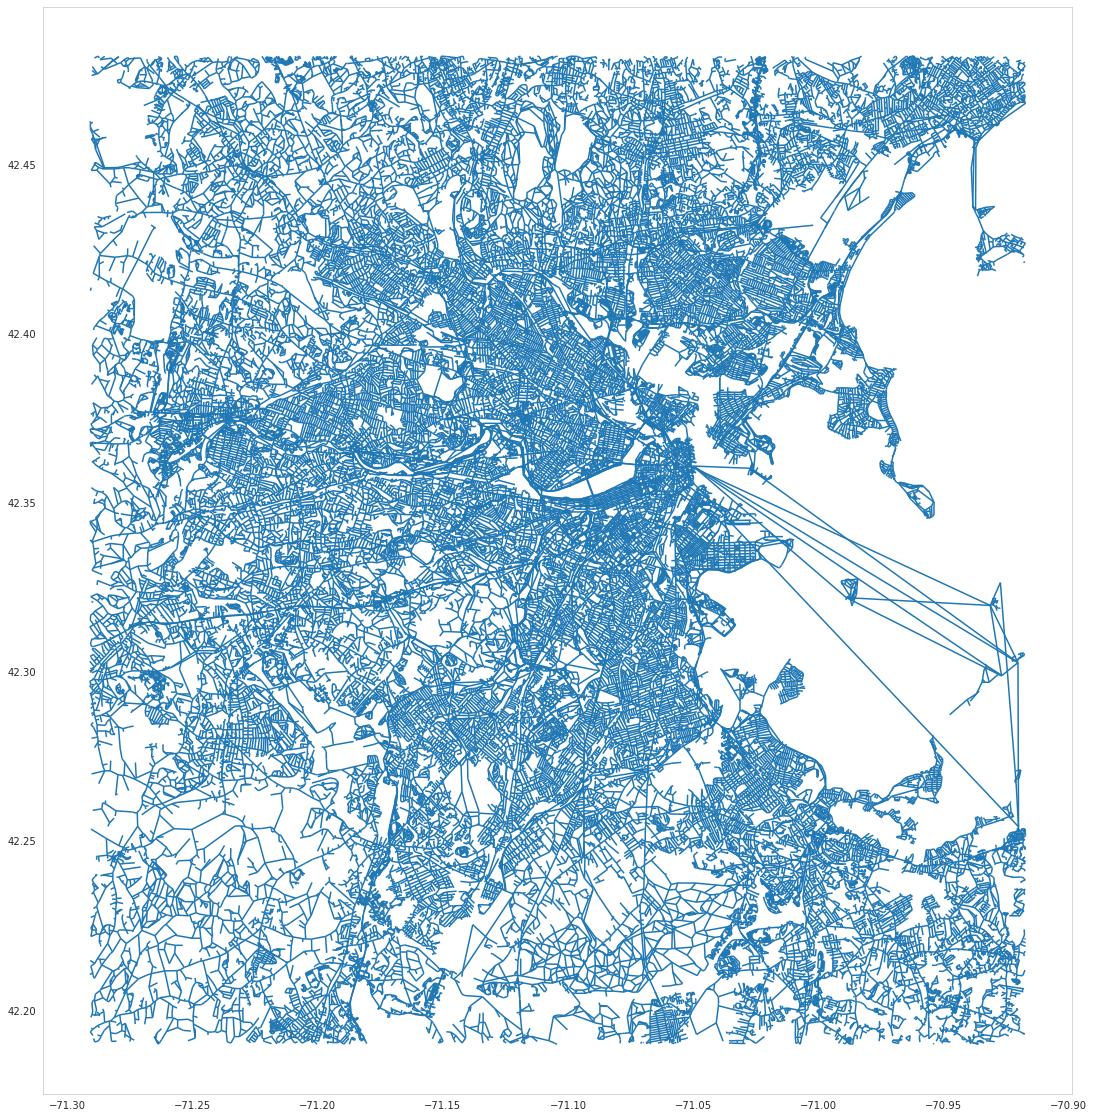

In [23]:
fig,ax=plt.subplots(figsize=(40,20))
ax.grid(False)
bs.plot(ax=ax)

# axins = zoomed_inset_axes(ax, 2, loc=1)
# axins2 = zoomed_inset_axes(ax, 2, loc=4)

# minx,miny,maxx,maxy =  states.query('STATE_NAME == "New Hampshire"').total_bounds
# axins.set_xlim(minx, maxx)
# axins.set_ylim(miny, maxy)
# states.query('STATE_NAME == "New Hampshire"').plot(ax=axins, edgecolor='black', color='none')

# minx,miny,maxx,maxy =  states.query('STATE_NAME == "West Virginia"').total_bounds
# axins2.set_xlim(minx, maxx)
# axins2.set_ylim(miny, maxy)
# states.query('STATE_NAME == "West Virginia"').plot(ax=axins2, edgecolor='black', color='none')


# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
# mark_inset(ax, axins2, loc1=2, loc2=3, fc="none", ec="0.5")

# # Plot zoom window
# #axins.plot()
# #axins2.plot()

# plt.setp(axins.get_xticklabels(), visible=False)
# plt.setp(axins.get_yticklabels(), visible=False)
# plt.setp(axins2.get_xticklabels(), visible=False)
# plt.setp(axins2.get_yticklabels(), visible=False)

# #ax.set_axis_off()
# plt.show()

## Raw network

In [104]:
with open('graph_original_sf.pk','rb') as file:
    raw=pickle.load(file,encoding='latin1')

In [105]:
node_id0=[e.source for e in raw['sub'].es()]
latlon0=[raw['sub'].vs[node]['pos'] for node in node_id0]

node_id1=[e.target for e in raw['sub'].es()]
latlon1=[raw['sub'].vs[node]['pos'] for node in node_id1]


In [106]:
from geojson import Point, Feature, FeatureCollection, dump, LineString
import geopandas as gpd

features = []
for i in range(len(node_id0)):
#     if latlon0[i][::-1][0]<-122.30 and latlon1[i][::-1][0]>-122.55 and latlon0[i][::-1][1]<37.9 and latlon0[i][::-1][1]>37.5:
    features.append(Feature(geometry=LineString((latlon0[i][::-1],latlon1[i][::-1])), properties={"segment_id": i,"source_node":node_id0[i],"target_node":node_id1[i]}))

In [107]:
# features

In [112]:
# feature_collection = FeatureCollection(features)

# with open('sf_raw_net.geojson', 'w') as f:
#     dump(feature_collection, f)

In [123]:
bs=gpd.read_file('sf_raw_net.geojson')
bs

,segment_id,source_node,target_node,geometry
0,0,0,474,"LINESTRING (-122.28135 37.82805, -122.28105 37..."
1,1,0,50845,"LINESTRING (-122.28135 37.82805, -122.28102 37..."
2,2,1,474,"LINESTRING (-122.28047 37.82825, -122.28105 37..."
3,3,1,1579,"LINESTRING (-122.28047 37.82825, -122.27935 37..."
4,4,1,25484,"LINESTRING (-122.28047 37.82825, -122.28044 37..."
...,...,...,...,...
119260,119260,85352,85353,"LINESTRING (-122.39586 37.76700, -122.39586 37..."
119261,119261,85354,85355,"LINESTRING (-122.39630 37.76665, -122.39630 37..."
119262,119262,85686,85687,"LINESTRING (-122.30161 37.81225, -122.30161 37..."
119263,119263,86192,86193,"LINESTRING (-122.30270 37.89844, -122.30270 37..."


In [124]:
len(bs)

119265

<AxesSubplot:>

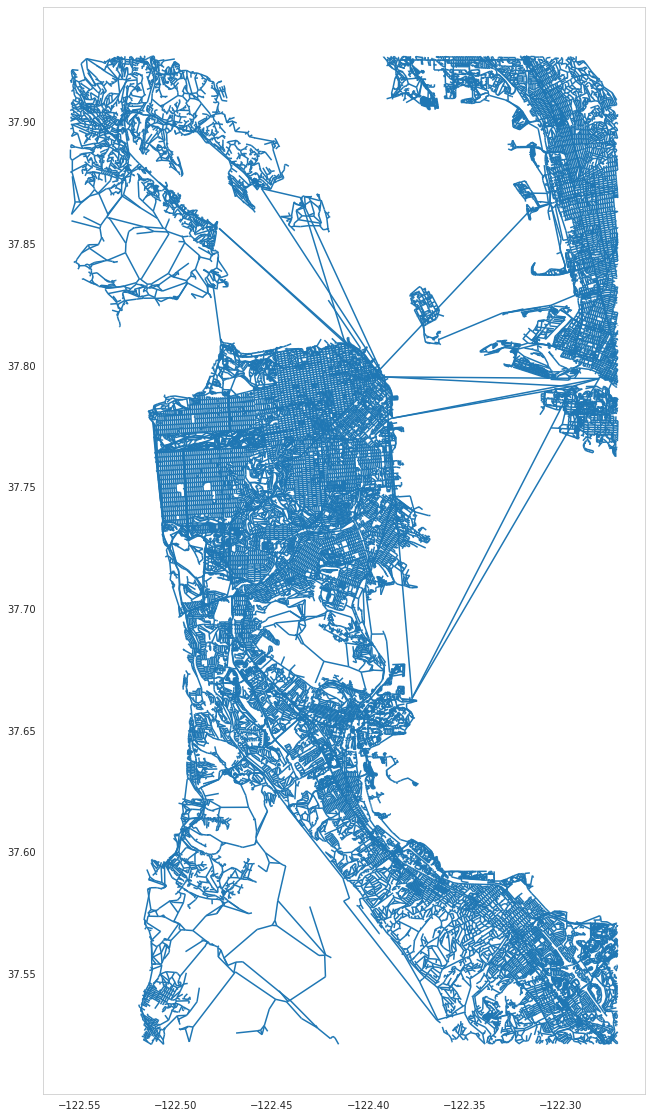

In [125]:
fig,ax=plt.subplots(figsize=(40,20))
ax.grid(False)
bs.plot(ax=ax)

In [88]:
# bs

In [234]:
cv=gpd.read_file('urban_design_measures.geojson')

In [179]:
# df=pd.read_csv('crosswalk_midpoints_osm_simplified.csv')
# df['segid_OSM']

In [200]:
# d=dict(zip(df.segid_OSM, df.segid_SIM))

In [235]:
cv=cv[['seg_id','uf','sw','fc','ve']]
cv['seg_id']=cv['seg_id'].astype(int)

In [236]:
df=pd.read_csv('seg_to_ed.csv')
df['edges']=df['edges'].apply(lambda x:ast.literal_eval(x))
df['edges']=df['edges'].apply(lambda x:str(x[0])+'_'+str(x[1]))
# d=dict(zip())

In [237]:
bo=pd.read_csv('ok.csv').iloc[:,1].values

In [238]:
d=dict(zip(df.seg_id,df.edges))

In [239]:
cv['segID']=cv['seg_id'].map(d)

In [240]:
cv=cv[cv['segID'].notna()]

In [241]:
cv.columns=['seg_id_osm', 'urban_furniture_std', 'sidewalk_std', 'facade_complexity_std', 'visual_enclosure_std', 'segid']

In [163]:
# cv.dtypes

In [229]:
cv.to_csv('SF_cv_measures_correct_edges.csv',index=False)

In [228]:
# cv.isna().sum()

In [243]:
# cv

In [245]:
cv.isna().sum()

seg_id_osm                   0
urban_furniture_std      30446
sidewalk_std             30446
facade_complexity_std    30857
visual_enclosure_std     30446
segid                        0
dtype: int64